# Painting with GANs

### Table of Contents
1. [Data Description](#Data-Description)
2. [Downloading data on local machine with Kaggle](#Downloading-data-on-your-local-machine-with-Kaggle)
3. [Extracting data into your local machine](#Extracting-data-into-your-local-machine)
4. [Data Preprocessing and Loading](#Data-Preprocessing-and-Loading)
5. [Defining dataset class and model inputs](#Defining-dataset-class-and-model-inputs)
6. [Building the Generator network](#Building-the-Generator-network)
7. [Building the Discriminator network](#Building-the-Discriminator-network)
8. [Calculating Model Loss](#Calculating-Model-Loss)
9. [Optimizing Model Parameters](#Optimizing-Model-Parameters)
10. [Building the GAN model](#Building-the-GAN-model)
11. [Hyperparameters](#Hyperparameters)
12. [Training the DCGAN](#Training-the-DCGAN)
13. [Evaluating the DCGAN](#Evaluating-the-DCGAN)

### Data Description

In this iPython Notebook, we will be using the art images curated by Kaggle user, [Danil](https://www.kaggle.com/thedownhill). While the data contains 5 different kinds of data, we will only be using images from the Paintings subdirectory. In addition, the data has already been separated into training and test dataset. For the purpose of our study (GAN is an unsupervised machine learning algorithm), however, we will concatenate both sources of data, and feed them in both networks.

More information regarding the dataset used can be found [here](https://www.kaggle.com/thedownhill/art-images-drawings-painting-sculpture-engraving).

### Downloading data on your local machine with Kaggle

You can refer to the following code chunks to learn how to download the data using Kaggle on the CLI (command line interface):

1. Download the [Kaggle API](https://github.com/Kaggle/kaggle-api): `pip install kaggle`.
2. Generate your API credentials by signing up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile - https://www.kaggle.com/(your-username)/account) and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials. Place this file in the location ~/.kaggle/kaggle.json (on Windows in the location C:\Users\<Windows-username>\.kaggle\kaggle.json).
3. Download the dataset using the following code on the CLI: `kaggle datasets download -d thedownhill/art-images-drawings-painting-sculpture-engraving` - this downloads a 581 Megabyte file that contains both the training and musemart data.

### Extracting data into your local machine

As we are dealing with zipped files, we unzip these files and save them to a new directory.

In [31]:
!mkdir data

mkdir: data: File exists


In [32]:
import os
import zipfile

def extract_data():
    current_path = os.getcwd()
    datafolder = os.path.join(current_path, 'data')
    
    if len(os.listdir(datafolder)): 
        print('Files are already extracted!')
        return 
    
    for file in os.listdir(current_path):
        if file.endswith('.zip'):
            ref = zipfile.ZipFile(file, 'r')
            ref.extractall(datafolder)
            ref.close()
    print('Files are extracted!')
    
extract_data()

Files are already extracted!


After extracting the files, it returns a folder named `dataset_updated` folder with 2 folders - `training_set` and `validation_set`. As we are interested in only generating images, we will only look at the `painting` folder in each folder.

In [33]:
def painting_dir():
    current_path = os.getcwd()
    data_directory = 'data/dataset_updated'
    
    train_paintings_dir = os.path.join(current_path, data_directory, 'training_set/painting')
    val_paintings_dir = os.path.join(current_path, data_directory, 'validation_set/painting')
    
    return train_paintings_dir, val_paintings_dir

train_painting_dir, val_painting_dir = painting_dir()

In [34]:
def painting_path(painting_dir): 
    return [os.path.join(painting_dir, image_path) for image_path in os.listdir(painting_dir)]

train_painting_path = painting_path(train_painting_dir)
val_painting_path = painting_path(val_painting_dir)

### Data Preprocessing and Loading

Next, we write a function to reshape the dimensions of all images in our training and test dataset to 64 by 64 pixels. The following code used to reshape images were adapted from [jhayes](https://github.com/jhayes14/GAN). First, we import key libraries used to manipulate image data:

1. numpy - for data manipulation
2. tensorflow - to build the GAN
3. cv2 - to read and reshape the image data
4. pickle - 
5. matplotlib - to plot the image

In [35]:
import numpy as np
import tensorflow as tf
import cv2
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [39]:
def load_image(img_path):
    img = cv2.imread(img_path)
    # Reshape image into 64 by 64 pixels
    img = np.float32(cv2.resize(img, (64, 64)))
    
    # Conduct feature scaling (range will be from (-1, 1))
    img = (2*img/255) - 1
    return img

Let's read the training and validation images into Python. We define a function that takes a `data_path` as its argument, and read the files in the path and store them in a numpy array.

In [40]:
def load_train_images(data_path):
    images = []
    for image_path in data_path:
        # As some data are corrupted, we use a try/except to catch such files and skip them
        try: 
            images.append(load_image(image_path))
        except: continue
    return np.array(images)

train_data = load_train_images(train_painting_path)
test_data = load_train_images(val_painting_path)

Let's take a look at some of the actual images, and how they look after reshaping and feature preprocessing!

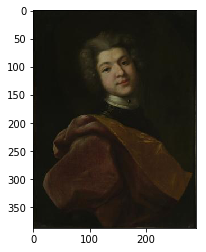

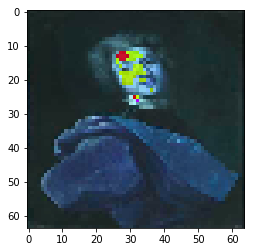

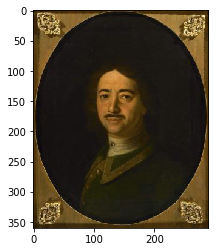

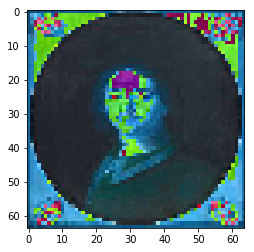

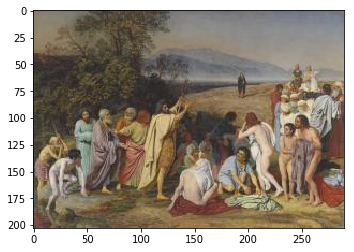

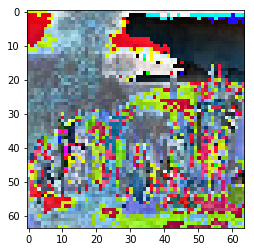

In [41]:
def show_image(image_path, reshaped_image):
    image = mpimg.imread(image_path)
    plt.imshow(image)
    plt.show()
    
    plt.imshow(reshaped_image)
    plt.show()
    
show_image(train_painting_path[0], train_data[0])
show_image(train_painting_path[2], train_data[1])
show_image(train_painting_path[3], train_data[2])

After feature pre-processing and reshaping, the new images have dimensions 64 by 64 pixels and look vaguely similar to that of the actual image.

As our goal here is to generate images that are similar to authentic artworks, we can concatenate both sources of data to form a new dataset.

In [8]:
train_data = np.concatenate([train_data, test_data])

### Defining dataset class and model inputs

Let's define a class that takes the training and test dataset as its inputs, and has a batches `method` that [yields](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/) batches. Finally, we will create some placeholders to hold the real and generated inputs. 

In [10]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

In [11]:
class Dataset:
    def __init__(self, train):
        self.trainlen = train.shape[3]
        self.train_x = train
        self.train_x = np.rollaxis(self.train_x, 3)
        
    def batches(self, batch_size):
        n_batches = self.trainlen//batch_size
        for ii in range(0, self.trainlen, batch_size):
            x = self.train_x[ii:ii+batch_size]
            yield x

### Building the Generator network

Next, we begin building our generator neural network. We start off with a fully connected dense hidden layer, and use batch normalization and convolutional transpose to 'transform' our images from the initial declared size (4, 4, 1024) to that of a 64 by 64 by 3 image.

Also, it is suggested in the DCGAN paper that we should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values (affected by the parameter, alpha). In addition, we use batch normalisation for this exercise.

Lastly, our choice of the activation function with be that of the hyperbolic tangent function, which outputs a value from -1 to 1.

**Model Architecture**: For the generator network, I opted for a 4-layer neural network, starting with 1 fully connected layer with Leaky ReLU activation, followed by 3 convolutional transpose layers, ending with a hyperbolic tangent activation function.

In [12]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    ''' Build the generator network.
    
        Arguments
        ---------
        z : Input tensor for the generator
        out_dim : Shape of the generator output
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out: 
    '''
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 8*8*128)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 8, 8, 128))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # current dimension: 8x8x128
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # current dimension: 16x16x64
        
        x3 = tf.layers.conv2d_transpose(x2, 32, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # current dimension: 32x32x32

        # Output layer - 64x64x3 image
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        
        return out

### Building the Discriminator network

The discriminator is similar to any other convolutional classifier. As the inputs to the discriminator is a 64x64x3 image, we can pass in a few convolutional layers before passing it through a fully connected layer at the end. We use a sigmoid activation for the discriminator network as the aim of the network is to differentiate between authentic artworks and images generated by the generator network.

**Model Architecture**: For the discriminator network, I opted for a 4 layer neural network: 3 Convolutional layers with Leaky ReLU activations, and a fully connected layer with sigmoid activation.

In [13]:
def discriminator(x, reuse=False, alpha=0.2):
    ''' Build the discriminator network.
    
        Arguments
        ---------
        x : Input tensor for the discriminator
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 64x64x3
        x1 = tf.layers.conv2d(x, 32, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # current dimension: 32x32x32
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #  current dimension: 16x16x64
        
        x3 = tf.layers.conv2d(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # current dimension: 8x8x128

        # Flatten it
        flat = tf.reshape(relu3, (-1, 8*8*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

### Calculating Model Loss

Next, we need to calculate the losses for the discriminator and generator. Recall that the discriminator wants to successfully discriminate between real and generated images, while the generator hopes to generate images that can 'fool' the discriminator into thinking that these generated images are authentic.

Thus, the discriminator losses consists of mainly 2 parts: 
1. predicting that authentic artworks are fake; or
2. predicting that generated images are real.

On the other hand, the generator losses consists of only 1 part:
1. creating images that the discriminator network thinks are fake i.e. getting caught by the discriminator.

In [14]:
def model_loss(real_input, z, output_dim, alpha=0.2):
    # build our generator and discriminator model
    g_model = generator(z, output_dim, reuse=False, alpha=alpha)
    d_model_real, d_real_logits = discriminator(real_input, reuse=False, alpha=alpha)
    d_model_fake, d_fake_logits = discriminator(g_model, reuse=True, alpha=alpha)
    
    # generate loss for discriminator with label smoothing
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, 
                                                labels=tf.ones_like(d_real_logits)*(0.9)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,
                                                labels=tf.zeros_like(d_fake_logits)))
    d_loss = d_loss_real + d_loss_fake

    # generate loss for generator
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,
                                                labels=tf.ones_like(d_fake_logits)))
    return d_loss, g_loss

### Optimizing Model Parameters

To train the discriminator and generator networks, we first need to find out the parameters of each network, and tweak them in order to minimise the loss of each network respectively. To do so, we can call [`tf.trainable_variables()`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables), which returns a list of all trainable variables. Recall that we set a variable scope previously - discriminator and generator; in this case, we can use the variable scope names to separate the variables which affect the generator and discriminator network.

We will use an AdamOptimizer to train both networks, and pass in a learning rate. For more information on the AdamOptimizer, you can click [here](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

### Building the GAN model

Let's define a class, `GAN` that takes the following inputs as arguments:
1. real_size = size of the real image (64, 64, 3)
2. z_size = size of the sampled data (100, )
3. learning_rate
4. alpha - The small, positive gradient passed through when the unit is not active
5. beta - The exponential decay rate for the 1st moment estimates

and does the following operations:
1. creates the real inputs and generates noisy inputs
2. calculates the discriminator and generator loss based on inputs
3. train the weights and biases of the discriminator and generator networks

Also, we will define 2 other methods, `train`, and `view_samples`.

The method, view_samples, returns the samples generated by the generator network after every 50 batches. Over time the generator should get better at generating images that can 'fool' the discriminator into thinking that they are real artworks - let's take a look at how these generated images change over time.

The method, train, takes a neural network, a dataset, the number of epochs and batch size as its inputs, and trains the model. Periodically (every 100 batches), it will show the images that the generator has generated. After training the model, it will save the weights and biases of the generator to a folder named `checkpoints`.

In [16]:
# Create checkpoints folder
!mkdir checkpoints

mkdir: checkpoints: File exists


In [17]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [18]:
def view_samples(epoch, samples, nrows, ncols, figsize=(10,10)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

For the `train` method, we save a version of random noise (`sample_z`), and check the progress of the generator network by passing in the same random noise over several different versions of the generator network. As the generator network becomes more adept at generating images, we expect the images (generated from the random noise) to look more similar to the artwork.

In [19]:
def train(net, dataset, epochs, batch_size, print_every=5, show_every=50, figsize=(10,5)):
    saver = tf.train.Saver()
    
    # Save a version of random noise
    sample_z = np.random.uniform(-1, 1, size=(12, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})
                
                # prints generator and discriminator loss every 5 batches
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                # prints images generated from generator network every 50 batches
                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 3, 4, figsize=figsize)
                    plt.show()
                    
        # Save the trained weights and biases
        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

### Hyperparameters

For our hyperparameters, we mainly adopt the parameters used by the authors of [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), as they found that these parameters were optimal. However, we make some slight changes due to the small number of training data that we have. 

After defining the hyperparameters, we can create an instance of the GAN class.

In [20]:
real_size = (64,64,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 30 # I opted for 30 epochs instead of 25 since we have only 2000+ data points.
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

### Training the DCGAN

Let's reshape our training and test data so that we can create an instance of the dataset class by passing them in as inputs. 

Following which, we pass the Dataset and GAN instances, the number of eopchs we want to run this model for as well as the batchsize, which are defined in the previous codeblock.

In [23]:
def rollaxis(data): return np.rollaxis(np.rollaxis(data, 0, 3), 3, 2)

trainset = rollaxis(train_data)
dataset = Dataset(trainset)

After defining all the methods and instantiating all of the classes, we proceed to train our GAN.

Epoch 1/30... Discriminator Loss: 1.0775... Generator Loss: 0.9200
Epoch 1/30... Discriminator Loss: 0.9289... Generator Loss: 1.1272
Epoch 1/30... Discriminator Loss: 0.7596... Generator Loss: 1.4730
Epoch 1/30... Discriminator Loss: 0.6296... Generator Loss: 1.7268
Epoch 2/30... Discriminator Loss: 0.6255... Generator Loss: 1.7782
Epoch 2/30... Discriminator Loss: 0.5475... Generator Loss: 1.9344
Epoch 2/30... Discriminator Loss: 0.4899... Generator Loss: 2.6113
Epoch 2/30... Discriminator Loss: 0.5174... Generator Loss: 2.1802
Epoch 3/30... Discriminator Loss: 0.4303... Generator Loss: 3.2582
Epoch 3/30... Discriminator Loss: 0.5342... Generator Loss: 2.0533


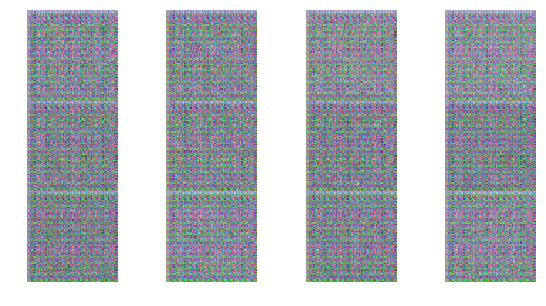

Epoch 3/30... Discriminator Loss: 0.4620... Generator Loss: 3.2524
Epoch 3/30... Discriminator Loss: 0.6300... Generator Loss: 3.4189
Epoch 4/30... Discriminator Loss: 0.4666... Generator Loss: 3.9996
Epoch 4/30... Discriminator Loss: 0.4630... Generator Loss: 3.7506
Epoch 4/30... Discriminator Loss: 0.4572... Generator Loss: 2.7684
Epoch 4/30... Discriminator Loss: 0.4156... Generator Loss: 3.2327
Epoch 5/30... Discriminator Loss: 0.3733... Generator Loss: 4.9727
Epoch 5/30... Discriminator Loss: 0.4052... Generator Loss: 4.4518
Epoch 5/30... Discriminator Loss: 0.6275... Generator Loss: 5.1965
Epoch 5/30... Discriminator Loss: 1.1415... Generator Loss: 5.5554


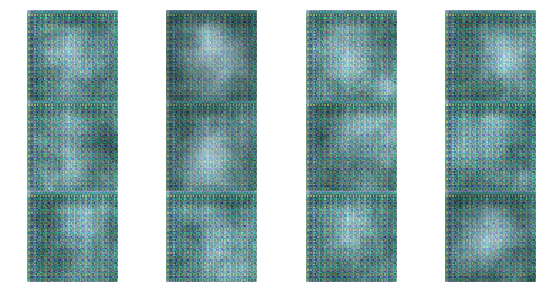

Epoch 5/30... Discriminator Loss: 0.8836... Generator Loss: 1.5964
Epoch 6/30... Discriminator Loss: 0.9604... Generator Loss: 3.1599
Epoch 6/30... Discriminator Loss: 1.3155... Generator Loss: 3.3643
Epoch 6/30... Discriminator Loss: 0.9713... Generator Loss: 2.4783
Epoch 6/30... Discriminator Loss: 1.1388... Generator Loss: 0.7523
Epoch 7/30... Discriminator Loss: 0.8194... Generator Loss: 2.0343
Epoch 7/30... Discriminator Loss: 0.9139... Generator Loss: 2.6268
Epoch 7/30... Discriminator Loss: 0.7001... Generator Loss: 2.0019
Epoch 7/30... Discriminator Loss: 0.7798... Generator Loss: 1.4439
Epoch 8/30... Discriminator Loss: 0.7863... Generator Loss: 1.4399


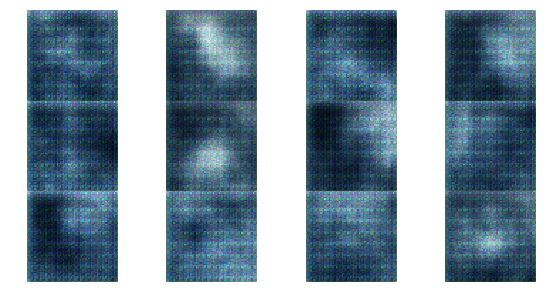

Epoch 8/30... Discriminator Loss: 0.7760... Generator Loss: 2.1292
Epoch 8/30... Discriminator Loss: 0.9597... Generator Loss: 2.9687
Epoch 8/30... Discriminator Loss: 0.7477... Generator Loss: 1.8644
Epoch 9/30... Discriminator Loss: 0.9710... Generator Loss: 2.8323
Epoch 9/30... Discriminator Loss: 0.8602... Generator Loss: 2.1306
Epoch 9/30... Discriminator Loss: 0.7509... Generator Loss: 1.7769
Epoch 9/30... Discriminator Loss: 1.0266... Generator Loss: 0.8993
Epoch 10/30... Discriminator Loss: 0.8190... Generator Loss: 1.3965
Epoch 10/30... Discriminator Loss: 0.8700... Generator Loss: 1.1005
Epoch 10/30... Discriminator Loss: 0.7838... Generator Loss: 1.6889


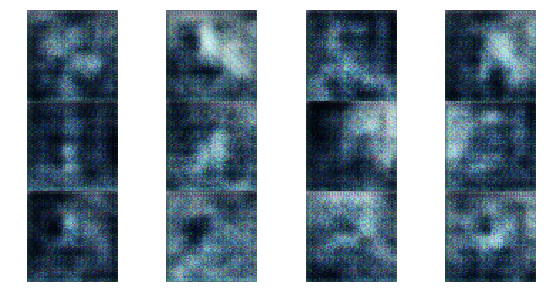

Epoch 10/30... Discriminator Loss: 0.8333... Generator Loss: 2.0680
Epoch 10/30... Discriminator Loss: 0.6493... Generator Loss: 1.9647
Epoch 11/30... Discriminator Loss: 0.8059... Generator Loss: 1.2495
Epoch 11/30... Discriminator Loss: 0.7577... Generator Loss: 1.5196
Epoch 11/30... Discriminator Loss: 0.7618... Generator Loss: 2.2703
Epoch 11/30... Discriminator Loss: 0.7194... Generator Loss: 1.5196
Epoch 12/30... Discriminator Loss: 1.3729... Generator Loss: 3.2107
Epoch 12/30... Discriminator Loss: 0.8390... Generator Loss: 2.2962
Epoch 12/30... Discriminator Loss: 0.9742... Generator Loss: 1.0651
Epoch 12/30... Discriminator Loss: 1.4031... Generator Loss: 3.3370


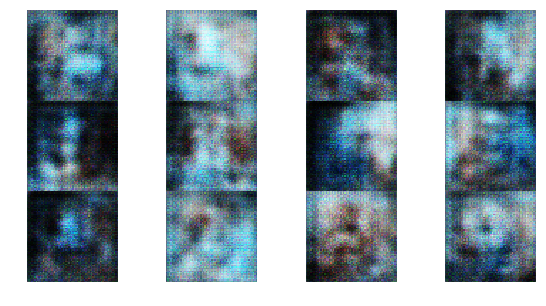

Epoch 13/30... Discriminator Loss: 0.8288... Generator Loss: 2.2276
Epoch 13/30... Discriminator Loss: 1.2266... Generator Loss: 0.6956
Epoch 13/30... Discriminator Loss: 0.8182... Generator Loss: 1.9338
Epoch 13/30... Discriminator Loss: 1.0137... Generator Loss: 2.5039
Epoch 14/30... Discriminator Loss: 0.8260... Generator Loss: 1.1800
Epoch 14/30... Discriminator Loss: 0.7222... Generator Loss: 1.7458
Epoch 14/30... Discriminator Loss: 0.8365... Generator Loss: 1.4626
Epoch 14/30... Discriminator Loss: 0.6811... Generator Loss: 1.7103
Epoch 15/30... Discriminator Loss: 0.6407... Generator Loss: 2.1914
Epoch 15/30... Discriminator Loss: 0.6631... Generator Loss: 1.8255


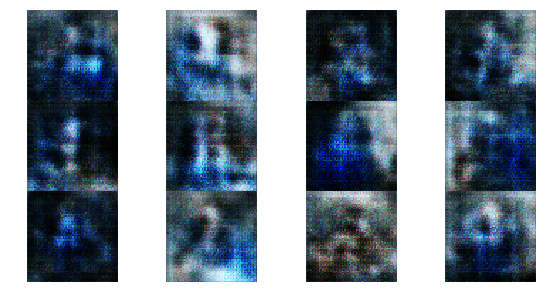

Epoch 15/30... Discriminator Loss: 0.7747... Generator Loss: 2.0738
Epoch 15/30... Discriminator Loss: 0.7291... Generator Loss: 1.7972
Epoch 15/30... Discriminator Loss: 0.6067... Generator Loss: 1.9249
Epoch 16/30... Discriminator Loss: 0.7120... Generator Loss: 1.5306
Epoch 16/30... Discriminator Loss: 0.8937... Generator Loss: 1.0810
Epoch 16/30... Discriminator Loss: 1.0633... Generator Loss: 0.8500
Epoch 16/30... Discriminator Loss: 0.8785... Generator Loss: 1.6531
Epoch 17/30... Discriminator Loss: 0.5558... Generator Loss: 2.4833
Epoch 17/30... Discriminator Loss: 0.5930... Generator Loss: 2.3437
Epoch 17/30... Discriminator Loss: 0.5660... Generator Loss: 2.5048


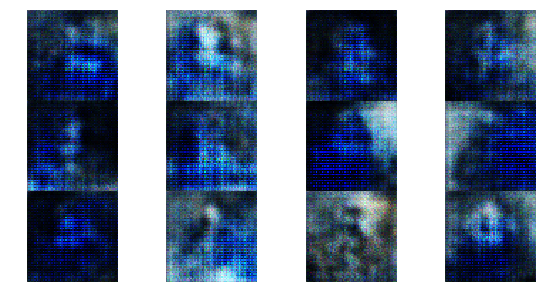

Epoch 17/30... Discriminator Loss: 0.5705... Generator Loss: 2.2673
Epoch 18/30... Discriminator Loss: 0.7040... Generator Loss: 2.4263
Epoch 18/30... Discriminator Loss: 0.7004... Generator Loss: 1.5302
Epoch 18/30... Discriminator Loss: 0.6294... Generator Loss: 2.0758
Epoch 18/30... Discriminator Loss: 0.6130... Generator Loss: 2.7976
Epoch 19/30... Discriminator Loss: 0.7099... Generator Loss: 1.5747
Epoch 19/30... Discriminator Loss: 0.6703... Generator Loss: 1.7360
Epoch 19/30... Discriminator Loss: 0.7946... Generator Loss: 1.3843
Epoch 19/30... Discriminator Loss: 2.0124... Generator Loss: 0.4185
Epoch 20/30... Discriminator Loss: 0.7689... Generator Loss: 1.6426


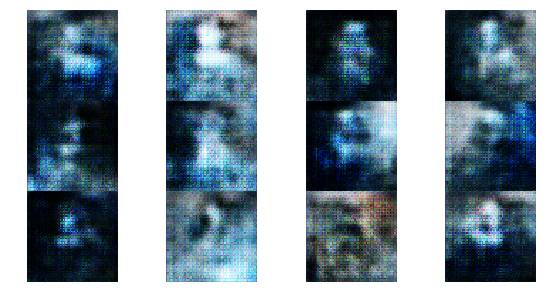

Epoch 20/30... Discriminator Loss: 0.6948... Generator Loss: 1.8178
Epoch 20/30... Discriminator Loss: 0.7172... Generator Loss: 1.8190
Epoch 20/30... Discriminator Loss: 0.6955... Generator Loss: 2.3237
Epoch 20/30... Discriminator Loss: 0.5055... Generator Loss: 2.8050
Epoch 21/30... Discriminator Loss: 0.6981... Generator Loss: 1.7080
Epoch 21/30... Discriminator Loss: 0.8944... Generator Loss: 1.1461
Epoch 21/30... Discriminator Loss: 1.1752... Generator Loss: 0.8257
Epoch 21/30... Discriminator Loss: 0.6538... Generator Loss: 1.7449
Epoch 22/30... Discriminator Loss: 0.6834... Generator Loss: 1.7279
Epoch 22/30... Discriminator Loss: 0.8589... Generator Loss: 2.7620


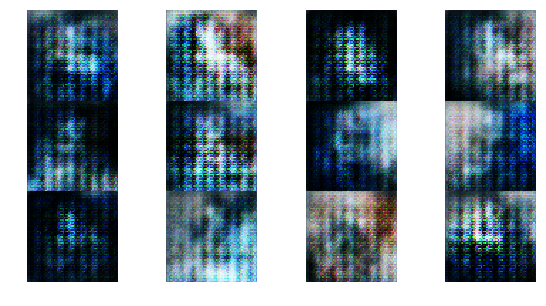

Epoch 22/30... Discriminator Loss: 0.7850... Generator Loss: 2.3171
Epoch 22/30... Discriminator Loss: 0.7086... Generator Loss: 2.0395
Epoch 23/30... Discriminator Loss: 0.8707... Generator Loss: 2.6992
Epoch 23/30... Discriminator Loss: 0.8788... Generator Loss: 1.3343
Epoch 23/30... Discriminator Loss: 0.7470... Generator Loss: 2.0704
Epoch 23/30... Discriminator Loss: 0.7319... Generator Loss: 1.7850
Epoch 24/30... Discriminator Loss: 0.7963... Generator Loss: 1.3514
Epoch 24/30... Discriminator Loss: 0.6879... Generator Loss: 1.9490
Epoch 24/30... Discriminator Loss: 0.7997... Generator Loss: 1.4875
Epoch 24/30... Discriminator Loss: 0.9238... Generator Loss: 1.0666


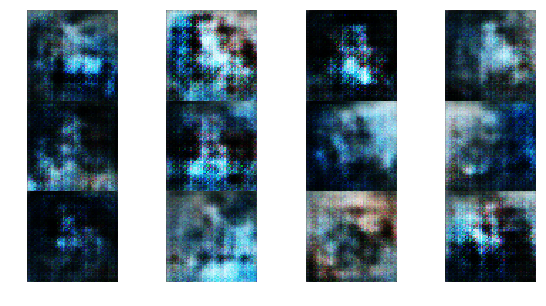

Epoch 25/30... Discriminator Loss: 0.8867... Generator Loss: 1.1652
Epoch 25/30... Discriminator Loss: 0.7971... Generator Loss: 1.5209
Epoch 25/30... Discriminator Loss: 0.8382... Generator Loss: 1.9694
Epoch 25/30... Discriminator Loss: 0.9102... Generator Loss: 2.2771
Epoch 25/30... Discriminator Loss: 0.6389... Generator Loss: 2.3057
Epoch 26/30... Discriminator Loss: 0.7180... Generator Loss: 1.8496
Epoch 26/30... Discriminator Loss: 0.8999... Generator Loss: 1.1370
Epoch 26/30... Discriminator Loss: 1.0255... Generator Loss: 0.8337
Epoch 26/30... Discriminator Loss: 0.7015... Generator Loss: 1.6408
Epoch 27/30... Discriminator Loss: 0.8783... Generator Loss: 1.0359


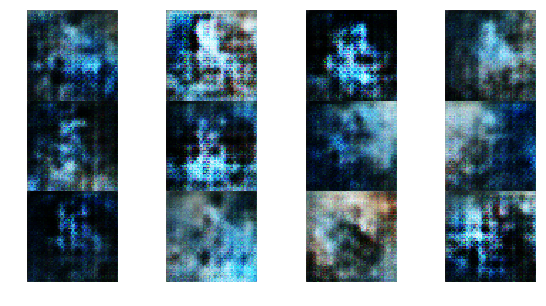

Epoch 27/30... Discriminator Loss: 0.7807... Generator Loss: 2.1871
Epoch 27/30... Discriminator Loss: 0.6551... Generator Loss: 2.0587
Epoch 27/30... Discriminator Loss: 0.7121... Generator Loss: 1.8342
Epoch 28/30... Discriminator Loss: 0.8168... Generator Loss: 2.4229
Epoch 28/30... Discriminator Loss: 0.8779... Generator Loss: 1.2361
Epoch 28/30... Discriminator Loss: 0.8182... Generator Loss: 1.5636
Epoch 28/30... Discriminator Loss: 0.7365... Generator Loss: 2.0548
Epoch 29/30... Discriminator Loss: 0.7824... Generator Loss: 1.3802
Epoch 29/30... Discriminator Loss: 0.7238... Generator Loss: 1.7205
Epoch 29/30... Discriminator Loss: 0.8086... Generator Loss: 1.5310


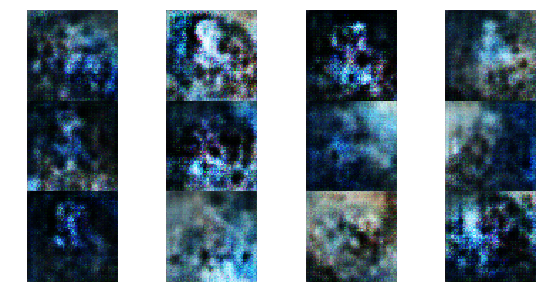

Epoch 29/30... Discriminator Loss: 1.1010... Generator Loss: 0.7827
Epoch 30/30... Discriminator Loss: 0.6971... Generator Loss: 1.7524
Epoch 30/30... Discriminator Loss: 0.7780... Generator Loss: 1.6110
Epoch 30/30... Discriminator Loss: 0.7513... Generator Loss: 1.5932
Epoch 30/30... Discriminator Loss: 0.8619... Generator Loss: 2.1984
Epoch 30/30... Discriminator Loss: 0.5549... Generator Loss: 2.5138


In [24]:
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

### Evaluating the DCGAN

Initially, the generated images started off as random noise. But over time, we observe that the generated images are getting closer and closer to looking like an authentic artwork. While I am not sufficiently close to becoming the next great artist, the generated images were able to 'fool' art dealers and curators. 

But apart from looking at the generated images, we can use the generator and discriminator losses as a proxy to see how well our GAN is performing. Generally, both losses should stabilise after some time - the discriminator and the generator are equally adept at their respective tasks, and have reached a standstill.

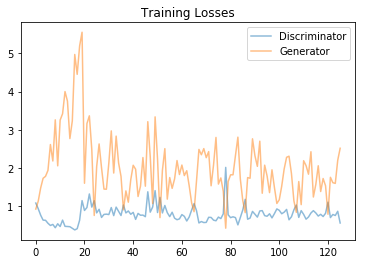

In [25]:
def plot_losses(losses):
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()
    plt.show()

plot_losses(losses)

Initially, the losses appear to vary wildly - the discriminator and generator seems to be learning how to discriminate and generate images. After about 20 to 25 timesteps, however, both networks seem to be doing very well. In particular, we note that the discriminator loss hovers around 1, while the generator loss oscillates between 1 and 3. This tells us that both models are at a standstill.